In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.metrics import confusion_matrix

from custom_models.augmentation import basic_plus_color_augmentation, basic_augmentation
from custom_models.bilinear_cnns import fe_resnet
from custom_models.cnns import simple_cnn_bn, base_resnet50
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from optimization.custom_losses import weighted_categorical_crossentropy

2025-01-20 15:05:50.971666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737385551.153860  168230 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737385551.201896  168230 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 15:05:51.527778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
target_dir = '../2025-01_EGGIM_Dataset3'
model_weights_directory = '../logs/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5
name = f'cv_patient_resnet_multi'
model_fold_dir = sorted(os.listdir(model_weights_directory))
model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.weights.h5')
              for x in model_fold_dir if x.startswith(name)]

In [3]:
model_dirs

['../logs/cv_patient_resnet_multi_65fold_0_20250119-145627/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_10_20250119-172449/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_11_20250119-173903/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_12_20250119-175307/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_13_20250119-180721/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_14_20250119-182139/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_15_20250119-183555/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_16_20250119-185017/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_17_20250119-190439/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_18_20250119-191945/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_19_20250119-193427/weights.weights.h5',
 '../logs/cv_patient_resnet_multi_65fold_1_20250119-151125/weights.weights.h5',
 '../logs/cv_patient_resnet_mu

In [4]:
dp = DatasetProcessor(target_dir)
df = dp.process()
patient_ids = np.load('configs/new_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [5]:
from sklearn.metrics import confusion_matrix

from evaluation.metrics import categorical_accuracy

from evaluation.metrics import specificity_per_class

from evaluation.metrics import sensitivity_per_class

metrics = []
y_true_ordinals = []
y_pred_ordinals = []
split = dp.patient_wise_split(df_togas,
                                      df_ipo,
                                      patient_ids,
                                      internal_train_size=0.9,
                                      target_variable='eggim_square',
                                      random_state=42)

for fold, (df_train, df_val, df_test) in enumerate(split):
    tf_test_df = get_tf_eggim_patch_dataset(df_test,
                                            num_classes=3,
                                            preprocess_fn=tf.keras.applications.resnet.preprocess_input)

    tf_test_df = tf_test_df.batch(batch_size)

    n_classes = 3  # Replace with the number of classes you have
    model = base_resnet50(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])


    model.load_weights(model_dirs[fold])

    y_true = np.concatenate([y for (_, y) in tf_test_df])
    y_pred = model.predict(tf_test_df)
    y_true_ordinal = np.argmax(y_true, axis=-1) # [0 0 1] -> 2
    y_pred_ordinal = np.argmax(y_pred, axis=-1)
    y_true_ordinals.append(y_true_ordinal)
    y_pred_ordinals.append(y_pred_ordinal)
    y_pred_one_hot = np.zeros_like(y_pred)
    y_pred_one_hot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1 # [0.2, 0.2, 0.6] -> [0, 0, 1]
    #print(y_pred)
    #print(y_pred_ordinal)
    #print(y_pred_one_hot)
    conf_matrix = confusion_matrix(y_true_ordinal, y_pred_ordinal,
                                   labels=[0, 1, 2])
    metrics.append([categorical_accuracy(y_true, y_pred_one_hot),
                    specificity_per_class(conf_matrix), sensitivity_per_class(conf_matrix),
                    conf_matrix])

I0000 00:00:1737385556.855316  168230 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8164 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:05:59.409470: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1737385560.635804  168323 service.cc:148] XLA service 0x74c7e4002890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737385560.635818  168323 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-20 15:

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1737385565.154971  168323 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:06:06.754278: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:06:13.043206: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-20 15:06:13.090263: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function '

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:06:17.060480: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-20 15:06:19.247876: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-20 15:06:19.727540: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 72 bytes spill stores, 72 bytes spill loads

2025-01-20 15:06:19.737121: I external/local_xla/xla/stream_executor/cuda/cuda_

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:06:29.889843: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-20 15:06:30.223373: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-20 15:06:30.378922: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 44 bytes spill stores, 44 bytes spill loads


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:06:37.470216: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-20 15:06:39.467139: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-20 15:06:40.066703: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-20 15:06:40.273460: I external/local_xla/xla/stream_executor/cuda/cuda_as

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:06:46.894370: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-20 15:06:46.984419: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-20 15:06:47.098319: I external/local_xla/xla/stream_executor/cuda/cuda_asm_

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:06:53.416212: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-20 15:06:53.447373: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-20 15:06:53.518457: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 316 bytes spill stores, 316 bytes spill load

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:06:58.951782: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-20 15:06:59.462567: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-20 15:06:59.766379: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 88 bytes spill stores, 88 bytes spill loads


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:07:19.090266: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-20 15:07:21.688382: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-20 15:07:21.782119: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1688', 4 bytes spill stores, 4 bytes spill loads

2025-01-20 15:07:22.045186: I external/local_xla/xla/stream_executor/cuda/cuda_as

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:08:26.733185: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:09:47.561331: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681', 16 bytes spill stores, 16 bytes spill loads

2025-01-20 15:09:47.565435: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1681_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-20 15:09:47.900145: I external/local_xla/xla/stream_executor/cuda/cuda_as

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:27: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-01-20 15:10:39.583106: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/goda/Desktop/tese/eggimazing/evaluation/metrics.py:48: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP / (TP + FN)
/home/goda/Desktop/tese/venv_3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [6]:
cat_acc = np.array([x[0] for x in metrics])
spec = np.array([x[1] for x in metrics])
sens = np.array([x[2] for x in metrics])
confs = np.array([x[3] for x in metrics], dtype=object)

/tmp/ipykernel_168230/4237036052.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])


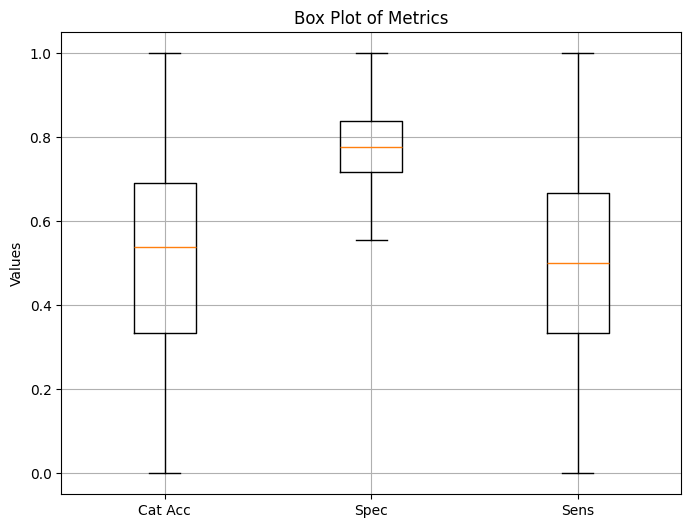

In [7]:
data = [cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()

In [8]:
from evaluation.eggim import *
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]

dp = DatasetProcessor(target_dir)
df = dp.process()
df['landmark'] = df['landmark'].apply(replace_landmark_name)
patient_ids = np.load('configs/new_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [9]:
df_togas

,bbox,eggim_global,eggim_square,landmark,image_directory,patient_id
0,"[218, 113, 442, 338]",0,0,distal body,../2025-01_EGGIM_Dataset3/20240117160000847.jpg,PT002
1,"[213, 228, 438, 452]",0,0,distal lc,../2025-01_EGGIM_Dataset3/20240117160333928.jpg,PT002
2,"[190, 231, 415, 455]",0,0,distal lc,../2025-01_EGGIM_Dataset3/20240117160406482.jpg,PT002
3,"[208, 235, 432, 460]",1,0,upper body r,../2025-01_EGGIM_Dataset3/20240117160431270.jpg,PT002
4,"[314, 153, 539, 378]",0,0,proximal ant gc/pw,../2025-01_EGGIM_Dataset3/20240119123159483.jpg,PT003
...,...,...,...,...,...,...
861,"[328, 212, 552, 436]",0,0,distal lc,../2025-01_EGGIM_Dataset3/20241016182413017.jpg,PT086
862,"[323, 178, 547, 403]",0,0,upper body r,../2025-01_EGGIM_Dataset3/20241016182430546.jpg,PT086
863,"[277, 140, 501, 364]",1,1,incisura r,../2025-01_EGGIM_Dataset3/20241016182711324.jpg,PT086
864,"[262, 161, 486, 386]",2,2,proximal ant gc/pw,../2025-01_EGGIM_Dataset3/20241016182746880.jpg,PT086


In [10]:
def compute_eggim_patient(patient_df, target_variable):
    df = patient_df[['landmark', target_variable]].value_counts()
    
    eggim = []
    eggim.append(df['proximal ant lc'].index[0])
    eggim.append(df['proximal ant gc/pw'].index[0])
    eggim.append(df['incisura r'].index[0])

    if 'distal body' in df.index and 'upper body ant' in df.index:
        eggim.append((df['distal body'].index[0] + df['upper body ant'].index[0]) / 2)
    elif 'distal body' in df.index:
        eggim.append(df['distal body'].index[0])
    else:
        eggim.append(df['upper body ant'].index[0])
    if 'upper body r' in df.index and 'distal lc' in df.index:
        eggim.append((df['distal lc'].index[0]+ df['upper body r'].index[0]) / 2)
    elif 'upper body r' in df.index:
        eggim.append(df['upper body r'].index[0])
    else:
        eggim.append(df['distal lc'].index[0])
    return eggim

eggim_scores = {}
eggim_total = [[],[]]
eggim0 =[[],[]]
eggim1 =[[],[]]
eggim2 =[[],[]]
eggim3 =[[],[]]
eggim4 =[[],[]]
for i, patient_id in enumerate(patient_ids):
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_pred_ordinals[i]

    eggim_global = compute_eggim_patient(df_patient,target_variable='eggim_global')
    eggim_pred = compute_eggim_patient(df_patient,target_variable='pred')

    for i in range(len(eggim_global)):
        eggim_global[i] = int(eggim_global[i])

    for i in range(len(eggim_pred)):
        eggim_pred[i] = int(eggim_pred[i])

    eggim_total[0] = eggim_total[0] + eggim_global
    eggim_total[1] = eggim_total[1] + eggim_pred
    eggim0[0].append(eggim_global[0])
    eggim0[1].append(eggim_pred[0])
    eggim1[0].append(eggim_global[1])
    eggim1[1].append(eggim_pred[1])
    eggim2[0].append(eggim_global[2])
    eggim2[1].append(eggim_pred[2])
    eggim3[0].append(eggim_global[3])
    eggim3[1].append(eggim_pred[3])
    eggim4[0].append(eggim_global[4])
    eggim4[1].append(eggim_pred[4])


def get_scores(cm):
    acc = np.trace(cm) / np.sum(cm)
    sen = np.diag(cm) / np.sum(cm, axis=1)
    spe = []
    for i in range(len(cm)):
        true_negatives = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        false_positives = np.sum(cm[:, i]) - cm[i, i]
        spe.append(true_negatives / (true_negatives + false_positives))

    return round(acc,4), np.round(sen,4), np.round(spe,4)

print(get_scores(confusion_matrix(eggim_total[0],eggim_total[1])))
print(get_scores(confusion_matrix(eggim0[0],eggim0[1])))
print(get_scores(confusion_matrix(eggim1[0],eggim1[1])))
print(get_scores(confusion_matrix(eggim2[0],eggim2[1])))
print(get_scores(confusion_matrix(eggim3[0],eggim3[1])))
print(get_scores(confusion_matrix(eggim4[0],eggim4[1])))


(0.52, array([0.4654, 0.4127, 0.9333]), array([0.9444, 0.7672, 0.6821]))
(0.6, array([0.4848, 0.4375, 1.    ]), array([0.9688, 0.9592, 0.5306]))
(0.4923, array([0.4091, 0.4444, 0.8333]), array([0.8571, 0.7679, 0.6792]))
(0.4769, array([0.4667, 0.1905, 0.9286]), array([0.9429, 0.8864, 0.4706]))
(0.6, array([0.5833, 0.8   ,    nan]), array([1.    , 0.7333, 0.8462]))
(0.4308, array([0.36  , 0.5833, 1.    ]), array([1.    , 0.5283, 0.8065]))


/tmp/ipykernel_168230/2358026696.py:59: RuntimeWarning: invalid value encountered in divide
  sen = np.diag(cm) / np.sum(cm, axis=1)


In [11]:
def compute_eggim_patient(patient_df, target_variable):
    df = patient_df[['landmark', target_variable]].value_counts()
    # we use index[0] to assume first landmark/score pair is correct
    eggim_antrum_incisura = df['proximal ant lc'].index[0] + df['proximal ant gc/pw'].index[0] + df['incisura r'].index[0]
    if 'distal body' in df.index and 'upper body ant' in df.index:
        eggim_body_1 = (df['distal body'].index[0] + df['upper body ant'].index[0]) / 2
    elif 'distal body' in df.index:
        eggim_body_1 = df['distal body'].index[0]
    else:
        eggim_body_1 = df['upper body ant'].index[0]
    if 'upper body r' in df.index and 'distal lc' in df.index:
        eggim_body_2 = (df['distal lc'].index[0]+ df['upper body r'].index[0]) / 2
    elif 'upper body r' in df.index:
        eggim_body_2 = df['upper body r'].index[0]
    else:
        eggim_body_2 = df['distal lc'].index[0]
    return eggim_antrum_incisura + eggim_body_1 + eggim_body_2

eggim_scores = {}

for i, patient_id in enumerate(patient_ids):
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_pred_ordinals[i]
    eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
    eggim_global = compute_eggim_patient(df_patient,
                                  target_variable='eggim_global')
    eggim_pred = compute_eggim_patient(df_patient,
                                  target_variable='pred')
    eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                    'eggim_pred': eggim_pred}
    
eggim_df = pd.DataFrame(eggim_scores).T

In [22]:
eggim_df.loc[(eggim_df['eggim_square'] < 5) & (eggim_df['eggim_pred'] >= 5)].index

Index(['PT049', 'PT074', 'PT045', 'PT004', 'PT030', 'PT082', 'PT050', 'PT068',
       'PT037', 'PT070', 'PT034', 'PT067', 'PT005', 'PT078', 'PT041', 'PT075',
       'PT063', 'PT039', 'PT023', 'PT048', 'PT031', 'PT064', 'PT066', 'PT054',
       'PT026', 'PT006', 'PT062', 'PT036', 'PT059'],
      dtype='object')

In [23]:
eggim_df.loc[(eggim_df['eggim_square'] >= 5) & (eggim_df['eggim_pred'] < 5)].index

Index([], dtype='object')

In [16]:
# minimum error of patch vs global labels
best_possible_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 0]))

In [17]:
# error of patch predictions vs patch labels
patch_eggim_mae =  np.mean(np.abs(eggim_df.iloc[:, 0] -  eggim_df.iloc[:, 2]))

In [18]:
patch_global_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 2]))

In [19]:
patch_eggim_mae

3.1846153846153844

In [20]:
# patch ground truth vs patch pred:
patch_eggim_mae

3.1846153846153844

In [21]:
# global ground truth vs patch pred
patch_global_eggim_mae

3.169230769230769

In [22]:
# global ground truth vs patch pred "adjusted" with minimum error in square labels
patch_global_eggim_mae - best_possible_eggim_mae

3.0615384615384613

In [23]:
best_possible_eggim_mae

0.1076923076923077